In [1]:
# Cell 1 — Imports & Constants
import time
import torch
import soundfile as sf
import librosa
import numpy as np
import noisereduce as nr
from panns_inference import AudioTagging
from sklearn.preprocessing import StandardScaler

In [2]:
PANNS_SR         = 32000
CHUNK_SEC        = 10
CHUNK_SAMPLES    = PANNS_SR * CHUNK_SEC
PROP_DECREASE    = 0.9
STATIONARY_NOISE = False
N_MELS           = 128
ALPHA            = 0.5

In [3]:
def denoise_audio(wave_np, sr):
    """Noise‐reduce a 1D NumPy waveform."""
    return nr.reduce_noise(
        y=wave_np, sr=sr,
        prop_decrease=PROP_DECREASE,
        stationary=STATIONARY_NOISE
    )

def calculate_mel_spectrogram(wave_np, sr, n_fft=2048, hop_length=512, n_mels=N_MELS):
    """Log‐MEL spectrogram."""
    mel_spec = librosa.feature.melspectrogram(
        y=wave_np, sr=sr,
        n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels
    )
    return librosa.power_to_db(mel_spec, ref=np.max)

def get_panns_embedding(wave_np, model, device):
    """PANNs Cnn14 embedding (1D NumPy)."""
    tensor = torch.from_numpy(wave_np).unsqueeze(0).to(device)
    with torch.no_grad():
        _, emb = model.inference(tensor)
    emb = emb.squeeze(0)
    return emb.cpu().numpy() if isinstance(emb, torch.Tensor) else np.array(emb)

def create_augmented_mel(log_mel, emb, n_mels=N_MELS, alpha=ALPHA):
    """Augment log-MEL with projected, normalized PANNs embed."""
    # project/embed to n_mels
    if emb.shape[0] != n_mels:
        if emb.shape[0] > n_mels:
            emb_proj = emb[:n_mels]
        else:
            emb_proj = np.pad(emb, (0, n_mels - emb.shape[0]))
    else:
        emb_proj = emb
    T = log_mel.shape[1]
    tiled = np.tile(emb_proj[:,None], (1, T))
    normed = StandardScaler().fit_transform(tiled.T).T
    return log_mel + alpha * normed

In [4]:
# 1) init PANNs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
panns = AudioTagging(checkpoint_path=None, device=device)
panns.model.eval()

# 2) load and resample
audio_path = 'SampleAudio.ogg'
wave, sr0 = sf.read(audio_path, dtype='float32')
if wave.ndim>1: wave = wave.mean(axis=1)
wave32 = librosa.resample(wave, orig_sr=sr0, target_sr=PANNS_SR)

# 3) grab a 10 s slice
segment = wave32[:CHUNK_SAMPLES]

Checkpoint path: /home/jovyan/panns_data/Cnn14_mAP=0.431.pth


/opt/conda/lib/python3.12/site-packages/panns_inference/inference.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=

Using CPU.


In [5]:
# Cell 4 — Time each step

# 1) Denoising
t0 = time.perf_counter()
den = denoise_audio(segment, PANNS_SR)
t1 = time.perf_counter()

# 2) MEL spectrogram
t2 = time.perf_counter()
mel = calculate_mel_spectrogram(den, PANNS_SR)
t3 = time.perf_counter()

# 3) PANNs embedding
t4 = time.perf_counter()
emb = get_panns_embedding(den, panns, device)
t5 = time.perf_counter()

# 4) Augmented MEL
t6 = time.perf_counter()
aug = create_augmented_mel(mel, emb)
t7 = time.perf_counter()

print(f"Denoise:          {t1-t0:.3f} s")
print(f"Calc MEL:         {t3-t2:.3f} s")
print(f"PANNs embed:      {t5-t4:.3f} s")
print(f"Augment MEL:      {t7-t6:.3f} s")


Denoise:          0.146 s
Calc MEL:         0.032 s
PANNs embed:      0.411 s
Augment MEL:      0.002 s


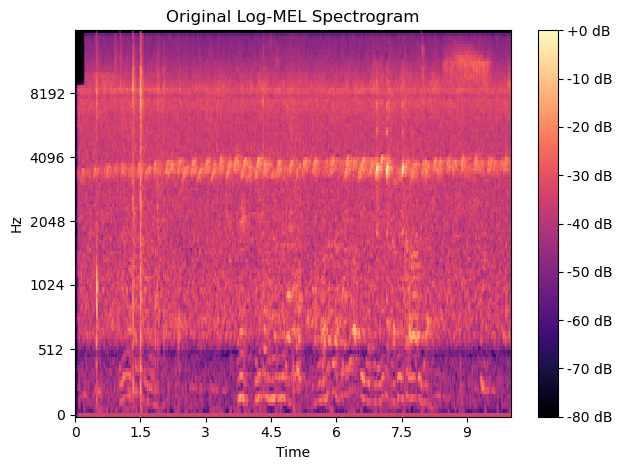

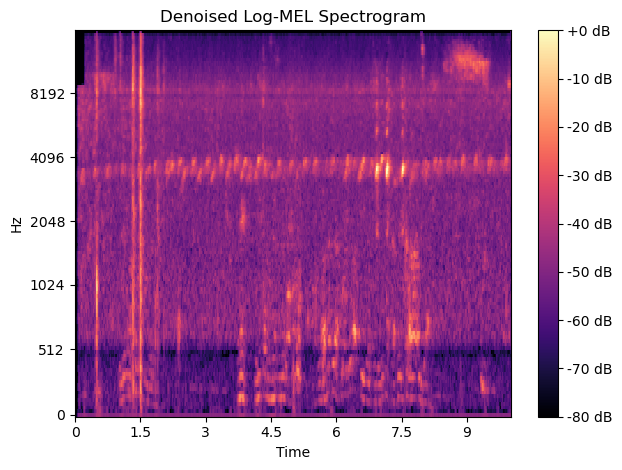

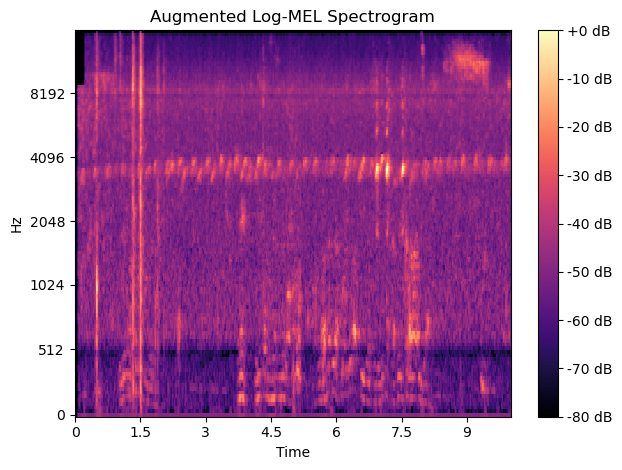

In [8]:
import matplotlib.pyplot as plt
import librosa.display

# 1) Compute the original MEL from the raw segment
orig_mel = calculate_mel_spectrogram(segment, PANNS_SR)

# 2) Plot each spectrogram in its own figure
for spec, title in [
    (orig_mel, "Original Log-MEL Spectrogram"),
    (mel,      "Denoised Log-MEL Spectrogram"),
    (aug,      "Augmented Log-MEL Spectrogram")
]:
    plt.figure()
    librosa.display.specshow(
        spec,
        sr=PANNS_SR,
        hop_length=512,
        x_axis="time",
        y_axis="mel"
    )
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()